<a href="https://colab.research.google.com/github/mihahafner/NER-seminar/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive folder

https://drive.google.com/drive/folders/1H7yLbPVODNG5ANgT2BWA5Y-xU6bhAAcf?usp=sharing

# Dataset source

https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus

# SETUP

In [2]:
import os
from google.colab import drive

# POVEZEMO SE NA GOOGLE DRIVE KJER SE SHRANJUJEJO VSE PODATKI
drive.mount('/content/drive')
ROOT = '/content/drive/MyDrive/bert'

# AUTORIZACIJA ZA KAGGLE 
os.environ['KAGGLE_USERNAME'] = 'mihahafner'
os.environ['KAGGLE_KEY'] = '74203e91e15b3c38bee230d76f2a710e'

# DOWNLOAD DATASET ZA TRENIRANJE
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
!kaggle datasets download -d abhishek/bert-base-uncased

# PRENOS ZIP-OV IZ KAGGLE V DRIVE
!unzip -o entity-annotated-corpus.zip -d /content/drive/MyDrive/bert/entity-annotated-corpus
!unzip -o bert-base-uncased.zip -d /content/drive/MyDrive/bert/bert-base-uncased

# ISTALACIJA IN PRIPRAVA PRED TRENIRANJEM
!pip install transformers
!mkdir /content/drive/MyDrive/bert/models

Mounted at /content/drive
 95% 25.0M/26.4M [00:01<00:00, 18.6MB/s]
100% 26.4M/26.4M [00:01<00:00, 19.9MB/s]
 99% 387M/389M [00:12<00:00, 50.4MB/s]
100% 389M/389M [00:12<00:00, 33.7MB/s]
Archive:  entity-annotated-corpus.zip
  inflating: /content/drive/MyDrive/bert/entity-annotated-corpus/ner.csv  
  inflating: /content/drive/MyDrive/bert/entity-annotated-corpus/ner_dataset.csv  
Archive:  bert-base-uncased.zip
  inflating: /content/drive/MyDrive/bert/bert-base-uncased/config.json  
  inflating: /content/drive/MyDrive/bert/bert-base-uncased/pytorch_model.bin  
  inflating: /content/drive/MyDrive/bert/bert-base-uncased/vocab.txt  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 2.1 MB/s 
     |████████████████████████████████| 6.6 MB 39.8 MB/s 
     |████████████████████████████████| 120 kB 29.2 MB/s 
mkdir: cannot create directory ‘/content/drive/MyDrive/bert/models’: File exists


# CONFIG

In [3]:
import joblib
import torch
import torch.nn as nn

import csv

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import model_selection

from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
import transformers
from torch.optim import Adadelta, Adagrad, Adam, Adamax, AdamW, ASGD, LBFGS, NAdam, Rprop, SGD, RMSprop, RAdam, SparseAdam

# CELOTNA KONFIGURACIJA PROJEKTA
class config:

    # HIRERPARAMETRI
    TRAIN_BATCH_SIZE = 4 # 2, 4, 8, 16, 32, 64
    EPOCHS = 1
    OPTIMIZER = AdamW  # Adadelta, Adagrad, Adam, Adamax, AdamW, ASGD, LBFGS, NAdam, Rprop, SGD, RMSprop, RAdam, SparseAdam
    LEARN_RATE = 0.0001 #  0.9 0.5 0.1 0.01 # 0.001, 0.0001, 0.00001, 0.000001

    # IME MODELA
    MODEL = f'{OPTIMIZER.__name__}_batch-{TRAIN_BATCH_SIZE}_epoch-{EPOCHS}_learn-{str(LEARN_RATE)[2:]}'

    # TRENING KONFIGURACIJA
    MAX_LEN = 128
    VALID_BATCH_SIZE = 8
    BASE_MODEL_PATH = f"{ROOT}/bert-base-uncased/"
    TRAINING_FILE = f"{ROOT}/entity-annotated-corpus/ner_dataset.csv"

    # TOKENIZER
    TOKENIZER = transformers.BertTokenizer.from_pretrained(
        BASE_MODEL_PATH,
        do_lower_case=True    
    )

# OBJEKT ZA LAZJO PRIPRAVO PRED TRENIRANJEM
class EntityDataset:

    # KONSTRUKTOR
    def __init__(self, texts, pos, tags):
        self.texts = texts
        self.pos = pos
        self.tags = tags
    
    # FUNKCIJA ZA IZACUN VELIKOSTI PODATKOV
    def __len__(self):
        return len(self.texts)
    
    # FUNKCIJA ZA PRIDOBIVANJE PODATKOV
    def __getitem__(self, item):
        text = self.texts[item]
        pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        target_pos = []
        target_tag =[]

        for i, s in enumerate(text):
            inputs = config.TOKENIZER.encode(
                s,
                add_special_tokens=False
            )
            # abhishek: ab ##hi ##sh ##ek
            input_len = len(inputs)
            ids.extend(inputs)
            target_pos.extend([pos[i]] * input_len)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:config.MAX_LEN - 2]
        target_pos = target_pos[:config.MAX_LEN - 2]
        target_tag = target_tag[:config.MAX_LEN - 2]

        ids = [101] + ids + [102]
        target_pos = [0] + target_pos + [0]
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = config.MAX_LEN - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_pos = target_pos + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)

        # VRACAJOCI PODATKI ZA TRENIRANJE IN VALIDACIJO
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

# TRENING FUNKCIJO
def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    final_loss = 0
    losses = []
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, _, loss = model(**data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += loss.item()
        losses.append(loss.item())
    
    # VRACA SE SPISEK IZGUB IN POVPRECNA IZGUBA MED TRENIRANJEM
    return losses, final_loss / len(data_loader)

# EVALUACIJSKA FUNKCIJA
def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    losses = []
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        _, _, loss = model(**data)
        losses.append(loss.item())
        final_loss += loss.item()
    # VRACA SE SPISEK IZGUB IN POVPRECNA IZGUBA MED TRENIRANJEM
    return losses, final_loss / len(data_loader)

# FUNKCIJA ZA IZRACUN IZGUBE (TIP IZRACUNA JE CROSS ENTROPY)
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

# DEFINICIJA MODELA KI SE TRENIRA
class EntityModel(nn.Module):
    def __init__(self, num_tag, num_pos):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.num_pos = num_pos

        # TRENIRA SE MODEL BERT...
        self.bert = transformers.BertModel.from_pretrained(
            config.BASE_MODEL_PATH, return_dict=False
        )

        # NOTRANJE HIPERPARAMETRE MODELA
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)

        # VELIKOST VHODNIH PODATKOV
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)
    
    # FORWARD PASS
    def forward(
        self, 
        ids, 
        mask, 
        token_type_ids, 
        target_pos, 
        target_tag
    ):
        o1, _ = self.bert(
            ids, 
            attention_mask=mask, 
            token_type_ids=token_type_ids
        )

        bo_tag = self.bert_drop_1(o1)
        bo_pos = self.bert_drop_2(o1)

        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)

        loss_tag = loss_fn(tag, target_tag, mask, self.num_tag)
        loss_pos = loss_fn(pos, target_pos, mask, self.num_pos)

        loss = (loss_tag + loss_pos) / 2

        return tag, pos, loss

# PREDPRIPRAVA PODATKOV V PODATKOVNE STRUKTURE
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

# PRIDOBITEV PODATKOVNIH STRUKTUR IZ SUROVIH CSV FILEOV.
sentences, pos, tag, enc_pos, enc_tag = process_data(config.TRAINING_FILE)

# SHRANJEVANJE META PODATKOV DATASETA.
meta_data = {
    "enc_pos": enc_pos,
    "enc_tag": enc_tag
}

joblib.dump(meta_data, "meta.bin")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

['meta.bin']

# TRAINING

In [3]:
# IZRACUN STEVIL RAZREDOV KI SE NAHAJAJO V DATASETU
num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))

# RAZDELITEV DATASETA NA TRENING IN TEST DATASET
(
    train_sentences,
    test_sentences,
    train_pos,
    test_pos,
    train_tag,
    test_tag) = model_selection.train_test_split(
    sentences, 
    pos, 
    tag, 
    random_state=42, # SEME NAKLJUCNOSTI
    test_size=0.1 # KOLIKO PROCENTOV BO V TESTING DATASETU
)

# USTVARIMO Z PREDEFINIRANIM RAZREDOM OBJEKTE ZA LAZJO MANIPULACIJO...
train_dataset = EntityDataset(
    texts=train_sentences, pos=train_pos, tags=train_tag
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config.TRAIN_BATCH_SIZE, num_workers=4
)

valid_dataset = EntityDataset(
    texts=test_sentences, pos=test_pos, tags=test_tag
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1
)

# PRIDOBIMO GPU KI BO IZVAJAL TRENIRANJE
device = torch.device("cuda")
# USTVARIMO MODEL
model = EntityModel(num_tag=num_tag, num_pos=num_pos)
# NALOZIMO MODEL V GPU
model.to(device)

# DEFINIRAMO DODATNE PARAMETRE MODELA IN OPTIMIZACIJSKEGA ALGORITMA
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(
                nd in n for nd in no_decay
            )
        ],
        "weight_decay": 0.0,
    },
]

# IZRACUNAMO STEVILO TRENING KORAKOV (ITERACIJ)
num_train_steps = int(
    len(train_sentences) / config.TRAIN_BATCH_SIZE * config.EPOCHS
)

# USTVARIMO ALTORITEM KI BO OPTIMIZIRAL MODEL
optimizer = config.OPTIMIZER(optimizer_parameters, lr=config.LEARN_RATE)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_train_steps
)

best_loss = np.inf
all_train_losses = []
all_test_losses = []

# GLAVNA TRENING ZANKA
for epoch in range(config.EPOCHS):

    # IZVEDE SE TRENING FUNKCIJA
    train_losses, train_loss = train_fn(
        train_data_loader, 
        model, 
        optimizer, 
        device, 
        scheduler
    )
    # IZVEDE SE EVALUACIJSKA FUNKCIJA
    test_losses, test_loss = eval_fn(
        valid_data_loader,
        model,
        device
    )
    
    # SHRANIMO INFORMACIJE TRENIRANJA V SPREMENLJIVKE
    all_train_losses += train_losses
    all_test_losses += test_losses

    print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
    
    # Ce najdemo model ki ima manjsi testing loss ga shranimo v datoteko.
    if test_loss < best_loss:
        torch.save(model.state_dict(), f'{ROOT}/models/{config.MODEL}.torch')
        best_loss = test_loss

# Na koncu treniranja shranimo vse informacije o treniranju v csv datoteko.
with open(f'{ROOT}/models/{config.MODEL}.csv', 'w') as f:
    writer = csv.DictWriter(f, ['train', 'validation', 'batch'])
    writer.writeheader()
    for i in range(len(all_test_losses)):
        writer.writerow({
            'batch': i,
            'train': all_train_losses[i],
            'validation': all_test_losses[i]
        })


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Some weights of the model checkpoint at /content/drive/MyDrive/bert/bert-base-uncased/ were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another

Train Loss = 0.12721847446466034 Valid Loss = 0.08956658656088014


# GRAPHS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


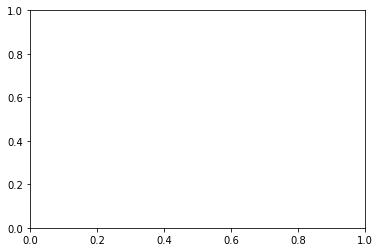

In [4]:
import shutil
import os
import csv
from matplotlib import pyplot as plt

data = []
# Sprehodimo se po direktoriju kjer se nahajajo modeli.
for fileName in os.listdir(f'{ROOT}/models'):

    # Zanima nas samo csv/ji
    if fileName.endswith('csv'):

        # Pridobimo inormacije o csv datoteki iz vsebine naslova datoteke.
        info = fileName.replace('.csv', '').split('_')

        # Preberemo csv datoteko in shranimo informacije v spisek slovarjev
        with open(f'{ROOT}/models/{fileName}', 'r') as file:
            rows = []
            for line in csv.DictReader(file):
                rows.append({key: float(value) for key, value in line.items()})
            
            
            # Sparsa se informacija o learning ratue.
            info[3] = info[3].replace('learn-', '')
            if info[3].startswith('-'):
              info[3] = '1e' + info[3]
            else:
              info[3] = '0.' + info[3]
            
            # Informacija o csv datoteki se shrani v slovar spiskov.
            data.append({
                'file': fileName,
                'optimizer': info[0],
                'learn_rate': float(info[3]),
                'batch_size': int(info[1].replace('batch-', '')),
                'epochs': int(info[2].replace('epoch-', '')),
                'rows': rows
            })

# Ce direktorij za grafe obstaja izbrisemo vse informacije notri.
try:
    shutil.rmtree(f'{ROOT}/graphs')
except:
    pass

# Direktorij se se enkrat ustvari.
os.mkdir(f'{ROOT}/graphs')

legend = []
scatter_x = []
scatter_y = []
scatter_area = []
scatter_model = []

# Pridobimo vse informacije iz csv pretvorjene oblike v grave in nove procesirane csv/je
for model in data:

    file_name = model['file']
    opti = model['optimizer']
    lr = model['learn_rate']
    batch = model['batch_size']
    rows = model['rows']
    
    x = [row['batch'] for row in rows]
    val_loss = [row['validation'] for row in rows]
    train_loss = [row['train'] for row in rows]
    
    scatter_x.append(batch)
    scatter_y.append(lr)
    scatter_model.append(opti)
    scatter_area.append(val_loss[-1])
    legend.append(f'{opti} LR{lr:.2E} batch {batch}')

    path = f'{ROOT}/graphs/{file_name.replace(".csv", "")}'
    os.mkdir(path)

    plt.title(f'Optimizer: {opti}, Learn rate: {lr}, Batch size: {batch}')
    plt.plot(x, val_loss)
    plt.plot(x, train_loss)
    plt.legend(['Validation loss', 'Train loss'])
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.savefig(f'{path}/loss.png')
    plt.clf()
    plt.cla()


for model in data:
    rows = model['rows']
    x = [row['batch'] for row in rows]
    val_loss = [row['validation'] for row in rows]
    plt.plot(x, val_loss)

path = f'{ROOT}/graphs/all'
os.mkdir(path)

plt.title(f'All models validation loss functions')
plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.tight_layout(rect=[0,0, 1, 1])
plt.savefig(f'{path}/validation_loss.png')
plt.clf()
plt.cla()

with open(f'{path}/learnRate_batch.csv', 'w') as file:
    csvFile = csv.DictWriter(file, fieldnames=['model', 'learn_rate', 'batch_size', 'val_loss'])
    csvFile.writeheader()
    for i in range(len(scatter_y)):
        csvFile.writerow({
            'model': scatter_model[i],
            'learn_rate': scatter_y[i],
            'batch_size': scatter_x[i],
            'val_loss': scatter_area[i],
        })

# Inference

In [12]:
models = []
# Koda za izbiro modela (samo tisti ki so natrenirani vec kot 1 epoch.)
print('IZBERI MODEL:')
i = 0
for path in os.listdir(f'{ROOT}/models'):
  if path.endswith('.torch'):
    epochs = int(path.split('_')[-2].replace('epoch-', ''))
    if epochs > 1:
      models.append(f'{ROOT}/models/{path}')
      print(f' {i}. {path}')
      i+=1

model_path = models[int(input("\nVnesi stevilko modela: "))]

# Slovar pomenk tagov v datasetu.
tag_meanings = {
    'geo': 'Geographical Entity',
    'org': 'Organization',
    'per': 'Person',
    'gpe': 'Geopolitical Entity',
    'tim': 'Time indicator',
    'art': 'Artifact',
    'eve': 'Event',
    'nat': 'Natural Phenomenon',
    'O': 'None'
}

meta_data = joblib.load("meta.bin")
enc_pos = meta_data["enc_pos"]
enc_tag = meta_data["enc_tag"]

num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))

# Definiramo stavek ki ga bomo preverili...

sentence = """The Ukrainian special service established that these individuals played key roles in the organization and holding of a fake plebiscite in eastern Ukraine,” the SBU said."""
#sentence = """President Bush visited London yesterday while it was snow"""

# Pretvorimo stavek v stevilski zapis
tokenized_sentence = config.TOKENIZER.encode(sentence)

# Razrezemo stavek na posamezne besede locene z prsledki...
sentence = sentence.split()
print(len(sentence), sentence)
print(len(tokenized_sentence), tokenized_sentence)

# Ustvarimo testni dataset z stavkom
test_dataset = EntityDataset(
    texts=[sentence], 
    pos=[[0] * len(sentence)], 
    tags=[[0] * len(sentence)]
)

# dobimo gpu device
device = torch.device("cuda")

# Ustvarimo objekt modela
model = EntityModel(num_tag=num_tag, num_pos=num_pos)

# Nalozimo shranjeno konfiguracijo v model ki smo jo dobili preko treniranja.
model.load_state_dict(torch.load(model_path))

# Nalozimo model v gpu.
model.to(device)

# Aktiviramo model za evaluacijo
with torch.no_grad():

    # Dobimo evaluacijski podatke.
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    
    # Posljemo testne podatke za evaluacijo v model
    tag, pos, _ = model(**data)

    # Pretvorimo izhodne podatke v cloveku prijazno obliko...
    tags = enc_tag.inverse_transform(
            tag.argmax(2).cpu().numpy().reshape(-1)
        )[:len(tokenized_sentence)]
    position =  enc_pos.inverse_transform(
            pos.argmax(2).cpu().numpy().reshape(-1)
        )[:len(tokenized_sentence)]

    # Izpisemo za vsako besedo kako jo je model labeliral.
    print('-------------------------------')
    for i in range(len(sentence)):
        print(f'{sentence[i]:<10} -> {tag_meanings[tags[i+1].split("-")[-1]]}')

IZBERI MODEL:
 0. Adam_batch-64_epoch-10_learn-0001.torch
 1. Adam_batch-4_epoch-50_learn-0001.torch
 2. Adam_batch-4_epoch-10_learn-0001.torch
 3. Adam_batch-4_epoch-20_learn-0001.torch
 4. AdamW_batch-4_epoch-20_learn-0001.torch

Vnesi stevilko modela: 0
26 ['The', 'Ukrainian', 'special', 'service', 'established', 'that', 'these', 'individuals', 'played', 'key', 'roles', 'in', 'the', 'organization', 'and', 'holding', 'of', 'a', 'fake', 'plebiscite', 'in', 'eastern', 'Ukraine,”', 'the', 'SBU', 'said.']
35 [101, 1996, 5969, 2569, 2326, 2511, 2008, 2122, 3633, 2209, 3145, 4395, 1999, 1996, 3029, 1998, 3173, 1997, 1037, 8275, 20228, 15878, 2483, 17847, 1999, 2789, 5924, 1010, 1524, 1996, 24829, 2226, 2056, 1012, 102]


Some weights of the model checkpoint at /content/drive/MyDrive/bert/bert-base-uncased/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


-------------------------------
The        -> None
Ukrainian  -> Geopolitical Entity
special    -> None
service    -> None
established -> None
that       -> None
these      -> None
individuals -> None
played     -> None
key        -> None
roles      -> None
in         -> None
the        -> None
organization -> None
and        -> None
holding    -> None
of         -> None
a          -> None
fake       -> None
plebiscite -> None
in         -> None
eastern    -> None
Ukraine,”  -> None
the        -> None
SBU        -> Geographical Entity
said.      -> Geographical Entity
